# SHA-256 Hashing on GPU with Numba

Small experiment to compare SHA-256 hashing on CPU vs GPU.


## Imports and SHA-256 constants

In [13]:
!nvidia-smi

import os
print("CUDA_VISIBLE_DEVICES =", os.environ.get("CUDA_VISIBLE_DEVICES"))

import cupy as cp
print("CuPy version:", cp.__version__)
print("CuPy device count:", cp.cuda.runtime.getDeviceCount())
cp.cuda.Device(0).use()
x = cp.arange(5)
print("CuPy test tensor on", x.device, "->", x)


Sun Nov 23 03:58:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             34W /   70W |     108MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
import numpy as np
from numba import cuda, uint32
import hashlib
import time
import random
import matplotlib.pyplot as plt

# Initial hash values (H0..H7)
H0 = np.array([
    0x6a09e667,
    0xbb67ae85,
    0x3c6ef372,
    0xa54ff53a,
    0x510e527f,
    0x9b05688c,
    0x1f83d9ab,
    0x5be0cd19
], dtype=np.uint32)

# Round constants K[0..63]
K = np.array([
    0x428a2f98, 0x71374491, 0xb5c0fbcf, 0xe9b5dba5,
    0x3956c25b, 0x59f111f1, 0x923f82a4, 0xab1c5ed5,
    0xd807aa98, 0x12835b01, 0x243185be, 0x550c7dc3,
    0x72be5d74, 0x80deb1fe, 0x9bdc06a7, 0xc19bf174,
    0xe49b69c1, 0xefbe4786, 0x0fc19dc6, 0x240ca1cc,
    0x2de92c6f, 0x4a7484aa, 0x5cb0a9dc, 0x76f988da,
    0x983e5152, 0xa831c66d, 0xb00327c8, 0xbf597fc7,
    0xc6e00bf3, 0xd5a79147, 0x06ca6351, 0x14292967,
    0x27b70a85, 0x2e1b2138, 0x4d2c6dfc, 0x53380d13,
    0x650a7354, 0x766a0abb, 0x81c2c92e, 0x92722c85,
    0xa2bfe8a1, 0xa81a664b, 0xc24b8b70, 0xc76c51a3,
    0xd192e819, 0xd6990624, 0xf40e3585, 0x106aa070,
    0x19a4c116, 0x1e376c08, 0x2748774c, 0x34b0bcb5,
    0x391c0cb3, 0x4ed8aa4a, 0x5b9cca4f, 0x682e6ff3,
    0x748f82ee, 0x78a5636f, 0x84c87814, 0x8cc70208,
    0x90befffa, 0xa4506ceb, 0xbef9a3f7, 0xc67178f2
], dtype=np.uint32)


## Device helper functions

In [15]:
@cuda.jit(device=True)
def to_uint32(x):
    # keep value in 32-bit range
    return uint32(x)


@cuda.jit(device=True)
def rotr(x, n):
    x = to_uint32(x)
    return to_uint32((x >> n) | (x << (32 - n)))


@cuda.jit(device=True)
def shr(x, n):
    x = to_uint32(x)
    return to_uint32(x >> n)


@cuda.jit(device=True)
def big_sigma0(x):
    x = to_uint32(x)
    return to_uint32(rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22))


@cuda.jit(device=True)
def big_sigma1(x):
    x = to_uint32(x)
    return to_uint32(rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25))


@cuda.jit(device=True)
def small_sigma0(x):
    x = to_uint32(x)
    return to_uint32(rotr(x, 7) ^ rotr(x, 18) ^ shr(x, 3))


@cuda.jit(device=True)
def small_sigma1(x):
    x = to_uint32(x)
    return to_uint32(rotr(x, 17) ^ rotr(x, 19) ^ shr(x, 10))


@cuda.jit(device=True)
def ch(x, y, z):
    x = to_uint32(x)
    y = to_uint32(y)
    z = to_uint32(z)
    return to_uint32((x & y) ^ ((~x) & z))


@cuda.jit(device=True)
def maj(x, y, z):
    x = to_uint32(x)
    y = to_uint32(y)
    z = to_uint32(z)
    return to_uint32((x & y) ^ (x & z) ^ (y & z))


## CUDA kernel

In [16]:
@cuda.jit
def sha256_kernel(blocks, digests):
    idx = cuda.grid(1)
    n = blocks.shape[0]

    if idx >= n:
        return

    # Message schedule array W[0..63]
    W = cuda.local.array(64, dtype=uint32)

    # W[0..15]: build from 64-byte block (big-endian)
    for t in range(16):
        i = t * 4
        b0 = blocks[idx, i]
        b1 = blocks[idx, i + 1]
        b2 = blocks[idx, i + 2]
        b3 = blocks[idx, i + 3]
        w = (uint32(b0) << 24) | (uint32(b1) << 16) | (uint32(b2) << 8) | uint32(b3)
        W[t] = to_uint32(w)

    # W[16..63]
    for t in range(16, 64):
        s0 = small_sigma0(W[t - 15])
        s1 = small_sigma1(W[t - 2])
        W[t] = to_uint32(W[t - 16] + s0 + W[t - 7] + s1)

    # Working variables
    a = to_uint32(H0[0])
    b = to_uint32(H0[1])
    c = to_uint32(H0[2])
    d = to_uint32(H0[3])
    e = to_uint32(H0[4])
    f = to_uint32(H0[5])
    g = to_uint32(H0[6])
    h = to_uint32(H0[7])

    # Main compression loop
    for t in range(64):
        S1 = big_sigma1(e)
        ch_val = ch(e, f, g)
        temp1 = to_uint32(h + S1 + ch_val + uint32(K[t]) + W[t])
        S0 = big_sigma0(a)
        maj_val = maj(a, b, c)
        temp2 = to_uint32(S0 + maj_val)

        h = g
        g = f
        f = e
        e = to_uint32(d + temp1)
        d = c
        c = b
        b = a
        a = to_uint32(temp1 + temp2)

    # Add to initial hash values
    a = to_uint32(a + H0[0])
    b = to_uint32(b + H0[1])
    c = to_uint32(c + H0[2])
    d = to_uint32(d + H0[3])
    e = to_uint32(e + H0[4])
    f = to_uint32(f + H0[5])
    g = to_uint32(g + H0[6])
    h = to_uint32(h + H0[7])

    # Store result as 32 bytes (big-endian)
    digests[idx, 0]  = (a >> 24) & 0xff
    digests[idx, 1]  = (a >> 16) & 0xff
    digests[idx, 2]  = (a >> 8)  & 0xff
    digests[idx, 3]  = a & 0xff

    digests[idx, 4]  = (b >> 24) & 0xff
    digests[idx, 5]  = (b >> 16) & 0xff
    digests[idx, 6]  = (b >> 8)  & 0xff
    digests[idx, 7]  = b & 0xff

    digests[idx, 8]  = (c >> 24) & 0xff
    digests[idx, 9]  = (c >> 16) & 0xff
    digests[idx, 10] = (c >> 8)  & 0xff
    digests[idx, 11] = c & 0xff

    digests[idx, 12] = (d >> 24) & 0xff
    digests[idx, 13] = (d >> 16) & 0xff
    digests[idx, 14] = (d >> 8)  & 0xff
    digests[idx, 15] = d & 0xff

    digests[idx, 16] = (e >> 24) & 0xff
    digests[idx, 17] = (e >> 16) & 0xff
    digests[idx, 18] = (e >> 8)  & 0xff
    digests[idx, 19] = e & 0xff

    digests[idx, 20] = (f >> 24) & 0xff
    digests[idx, 21] = (f >> 16) & 0xff
    digests[idx, 22] = (f >> 8)  & 0xff
    digests[idx, 23] = f & 0xff

    digests[idx, 24] = (g >> 24) & 0xff
    digests[idx, 25] = (g >> 16) & 0xff
    digests[idx, 26] = (g >> 8)  & 0xff
    digests[idx, 27] = g & 0xff

    digests[idx, 28] = (h >> 24) & 0xff
    digests[idx, 29] = (h >> 16) & 0xff
    digests[idx, 30] = (h >> 8)  & 0xff
    digests[idx, 31] = h & 0xff


## Helper functions (padding, data, CPU hashing)

In [17]:
def pad_single_block(message: bytes, block_size=64) -> bytes:
    """Pad message (len <= 55) to exactly one 512-bit (64-byte) SHA-256 block."""
    ml = len(message)
    assert ml <= 55, "This simple padding assumes message length <= 55 bytes"

    padded = bytearray(message)
    padded.append(0x80)

    while len(padded) < 56:
        padded.append(0x00)

    bit_len = ml * 8
    padded.extend(bit_len.to_bytes(8, byteorder='big'))

    assert len(padded) == 64
    return bytes(padded)


def generate_random_messages(N, min_len=5, max_len=40):
    """Generate N random ASCII messages with length between min_len and max_len (<= 55)."""
    msgs = []
    for _ in range(N):
        L = random.randint(min_len, max_len)
        s = ''.join(random.choice('abcdefghijklmnopqrstuvwxyz0123456789')
                    for _ in range(L))
        msgs.append(s.encode('utf-8'))
    return msgs


def cpu_sha256_hashes(messages):
    """Compute SHA-256 using hashlib on CPU for each message."""
    N = len(messages)
    out = np.zeros((N, 32), dtype=np.uint8)
    for i, m in enumerate(messages):
        h = hashlib.sha256(m).digest()
        out[i, :] = np.frombuffer(h, dtype=np.uint8)
    return out


## Run the experiment


===== N = 1000 messages =====
CPU time : 0.0019 s  (523,699 hashes/sec)
GPU time : 0.0001 s  (8,128,496 hashes/sec)
Sample digests match for this N.

===== N = 5000 messages =====
CPU time : 0.0090 s  (554,055 hashes/sec)
GPU time : 0.0001 s  (51,909,703 hashes/sec)
Sample digests match for this N.

===== N = 10000 messages =====
CPU time : 0.0186 s  (536,603 hashes/sec)
GPU time : 0.0001 s  (70,138,863 hashes/sec)
Sample digests match for this N.

===== N = 20000 messages =====
CPU time : 0.0393 s  (509,058 hashes/sec)
GPU time : 0.0002 s  (100,462,371 hashes/sec)
Sample digests match for this N.

===== N = 50000 messages =====
CPU time : 0.0874 s  (571,874 hashes/sec)
GPU time : 0.0004 s  (130,338,844 hashes/sec)
Sample digests match for this N.

===== OVERALL SUMMARY =====
N =   1000 | CPU: 0.0019s (523,699 h/s) | GPU: 0.0001s (8,128,496 h/s) | Speedup: 15.52x
N =   5000 | CPU: 0.0090s (554,055 h/s) | GPU: 0.0001s (51,909,703 h/s) | Speedup: 93.69x
N =  10000 | CPU: 0.0186s (536,60

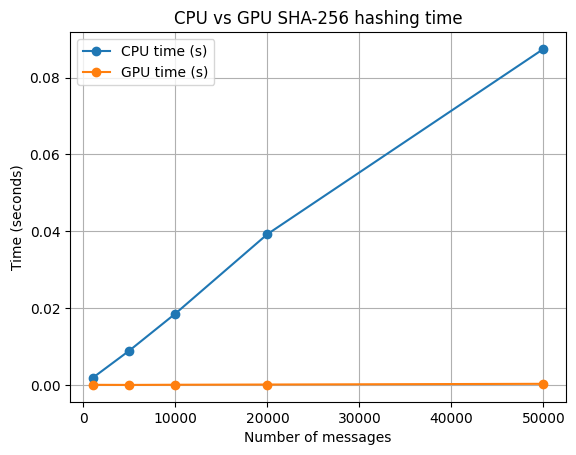

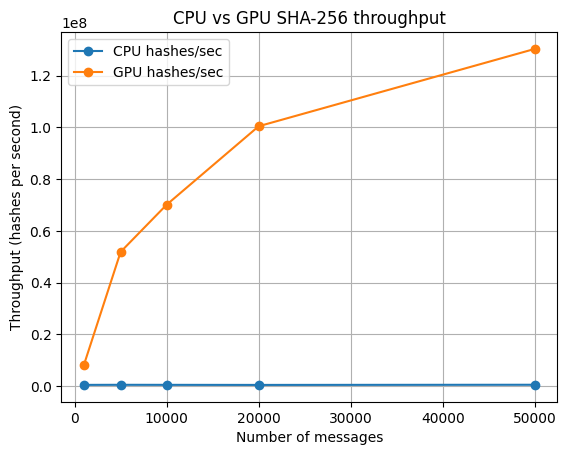

In [19]:
def run_experiment():
    # batch sizes
    Ns = [1000, 5000, 10000, 20000, 50000]

    cpu_times = []
    gpu_times = []
    cpu_speeds = []  # hashes/sec
    gpu_speeds = []  # hashes/sec

    for N in Ns:
        print(f"\n===== N = {N} messages =====")
        messages = generate_random_messages(N)

        # ----- CPU baseline -----
        start_cpu = time.time()
        cpu_digests = cpu_sha256_hashes(messages)
        end_cpu = time.time()
        cpu_time = end_cpu - start_cpu
        cpu_times.append(cpu_time)

        cpu_speed = N / cpu_time
        cpu_speeds.append(cpu_speed)

        print(f"CPU time : {cpu_time:.4f} s  ({cpu_speed:,.0f} hashes/sec)")

        # ----- Prepare padded blocks for GPU -----
        blocks = np.zeros((N, 64), dtype=np.uint8)
        for i, m in enumerate(messages):
            padded = pad_single_block(m)
            blocks[i, :] = np.frombuffer(padded, dtype=np.uint8)

        # ----- GPU SHA-256 -----
        d_blocks = cuda.to_device(blocks)
        d_digests = cuda.device_array((N, 32), dtype=np.uint8)

        threads_per_block = 128
        blocks_per_grid = (N + threads_per_block - 1) // threads_per_block

        # warmup to avoid JIT time in measurement
        sha256_kernel[blocks_per_grid, threads_per_block](d_blocks, d_digests)
        cuda.synchronize()

        start_gpu = time.time()
        sha256_kernel[blocks_per_grid, threads_per_block](d_blocks, d_digests)
        cuda.synchronize()
        end_gpu = time.time()

        gpu_time = end_gpu - start_gpu
        gpu_times.append(gpu_time)

        gpu_speed = N / gpu_time
        gpu_speeds.append(gpu_speed)

        print(f"GPU time : {gpu_time:.4f} s  ({gpu_speed:,.0f} hashes/sec)")

        # correctness check on a small sample
        gpu_digests = d_digests.copy_to_host()
        ok = True
        for i in range(min(5, N)):
            if not np.array_equal(cpu_digests[i], gpu_digests[i]):
                ok = False
                print(f"Mismatch at index {i}:")
                print("CPU:", cpu_digests[i].tobytes().hex())
                print("GPU:", gpu_digests[i].tobytes().hex())
                break

        if ok:
            print("Sample digests match for this N.")
        else:
            print("Mismatch detected for this N.")

    print("\n===== OVERALL SUMMARY =====")
    for N, ct, gt, cs, gs in zip(Ns, cpu_times, gpu_times, cpu_speeds, gpu_speeds):
        print(
            f"N = {N:6d} | "
            f"CPU: {ct:.4f}s ({cs:,.0f} h/s) | "
            f"GPU: {gt:.4f}s ({gs:,.0f} h/s) | "
            f"Speedup: {ct/gt:.2f}x"
        )

    # ----- Plot 1: CPU vs GPU time -----
    plt.figure()
    plt.plot(Ns, cpu_times, marker="o", label="CPU time (s)")
    plt.plot(Ns, gpu_times, marker="o", label="GPU time (s)")
    plt.xlabel("Number of messages")
    plt.ylabel("Time (seconds)")
    plt.title("CPU vs GPU SHA-256 hashing time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----- Plot 2: CPU vs GPU speed (hashes/sec) -----
    plt.figure()
    plt.plot(Ns, cpu_speeds, marker="o", label="CPU hashes/sec")
    plt.plot(Ns, gpu_speeds, marker="o", label="GPU hashes/sec")
    plt.xlabel("Number of messages")
    plt.ylabel("Throughput (hashes per second)")
    plt.title("CPU vs GPU SHA-256 throughput")
    plt.legend()
    plt.grid(True)
    plt.show()

run_experiment()
